In [11]:
import numpy as np
from math import *

In [12]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

In [13]:
policy = np.zeros((MAX_CARS+1, MAX_CARS+1))
stateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))

In [14]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i,j])

In [15]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)

In [16]:
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x*10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam,x) / factorial(x)
    return pBackup[key]

In [17]:
POISSON_UPPER_BOUND = 11

In [18]:
newStateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))
improvePolicy = False
policyStable = False

In [19]:
def expectedReturn(state, action, stateValue):
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    returns -= COST_OF_MOVING * np.absolute(action)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    # Number of cars at the end of the day
                    returns += prob * (rewards + DISCOUNT_RATE * stateValue[carsLoc1_prime, carsLoc2_prime])
    return returns

In [20]:
while policyStable == False:
    ## Policy Evaluation
    print("Policy Eval")
    delta = 0.0
    for i,j in states:
        v = stateVal[i,j].copy()
        stateVal[i,j] = np.max([expectedReturn([i,j], action, stateVal) for action in actions])
        delta = np.maximum(delta, np.absolute(v-stateVal[i,j]))
    print(delta)
    if delta < 1e-4:
        print("Almost converged")
        improvePolicy = True

    ## Policy Improvement
    if improvePolicy == True:
        print("Improve Policy")
        newPolicy = np.zeros((MAX_CARS+1, MAX_CARS+1))
        for i,j in states:
            actionReturns = []
            for action in actions:
                if ((action >= 0) and (i >= action)) or ((action < 0) and j >= np.absolute(action)):
                    actionReturns.append(expectedReturn([i,j], action, stateVal))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i,j] = actions[bestAction]
        
        policy = newPolicy
        policyStable = True
    
# exec time: 100 min

Policy Eval
291.23828578627416
Policy Eval
110.08522945213124
Policy Eval
86.45237407524397
Policy Eval
64.83211638928634
Policy Eval
48.61029824590963
Policy Eval
37.248377413244725
Policy Eval
30.130009806997094
Policy Eval
24.618501816290745
Policy Eval
20.07106835822856
Policy Eval
16.344664794175458
Policy Eval
13.301526411833095
Policy Eval
10.822141122355447
Policy Eval
8.80443048418374
Policy Eval
7.162569482094341
Policy Eval
5.8266180142106805
Policy Eval
4.74003674095178
Policy Eval
3.856287449682611
Policy Eval
3.1373809733890425
Policy Eval
2.5525459769785925
Policy Eval
2.076770678144669
Policy Eval
1.6897071371491847
Policy Eval
1.374805265427824
Policy Eval
1.118608172428253
Policy Eval
0.910170682225953
Policy Eval
0.740586597315712
Policy Eval
0.6026083143361802
Policy Eval
0.4903441728301914
Policy Eval
0.39900095350691345
Policy Eval
0.3246788068976798
Policy Eval
0.26420445422974126
Policy Eval
0.21499625311338377
Policy Eval
0.17495430793229616
Policy Eval
0.14237

In [21]:
np.save("/system/user/studentwork/mederits/Research/RL/jacks_car_rental_policy_GPI_value_iteration_version.npy", policy)

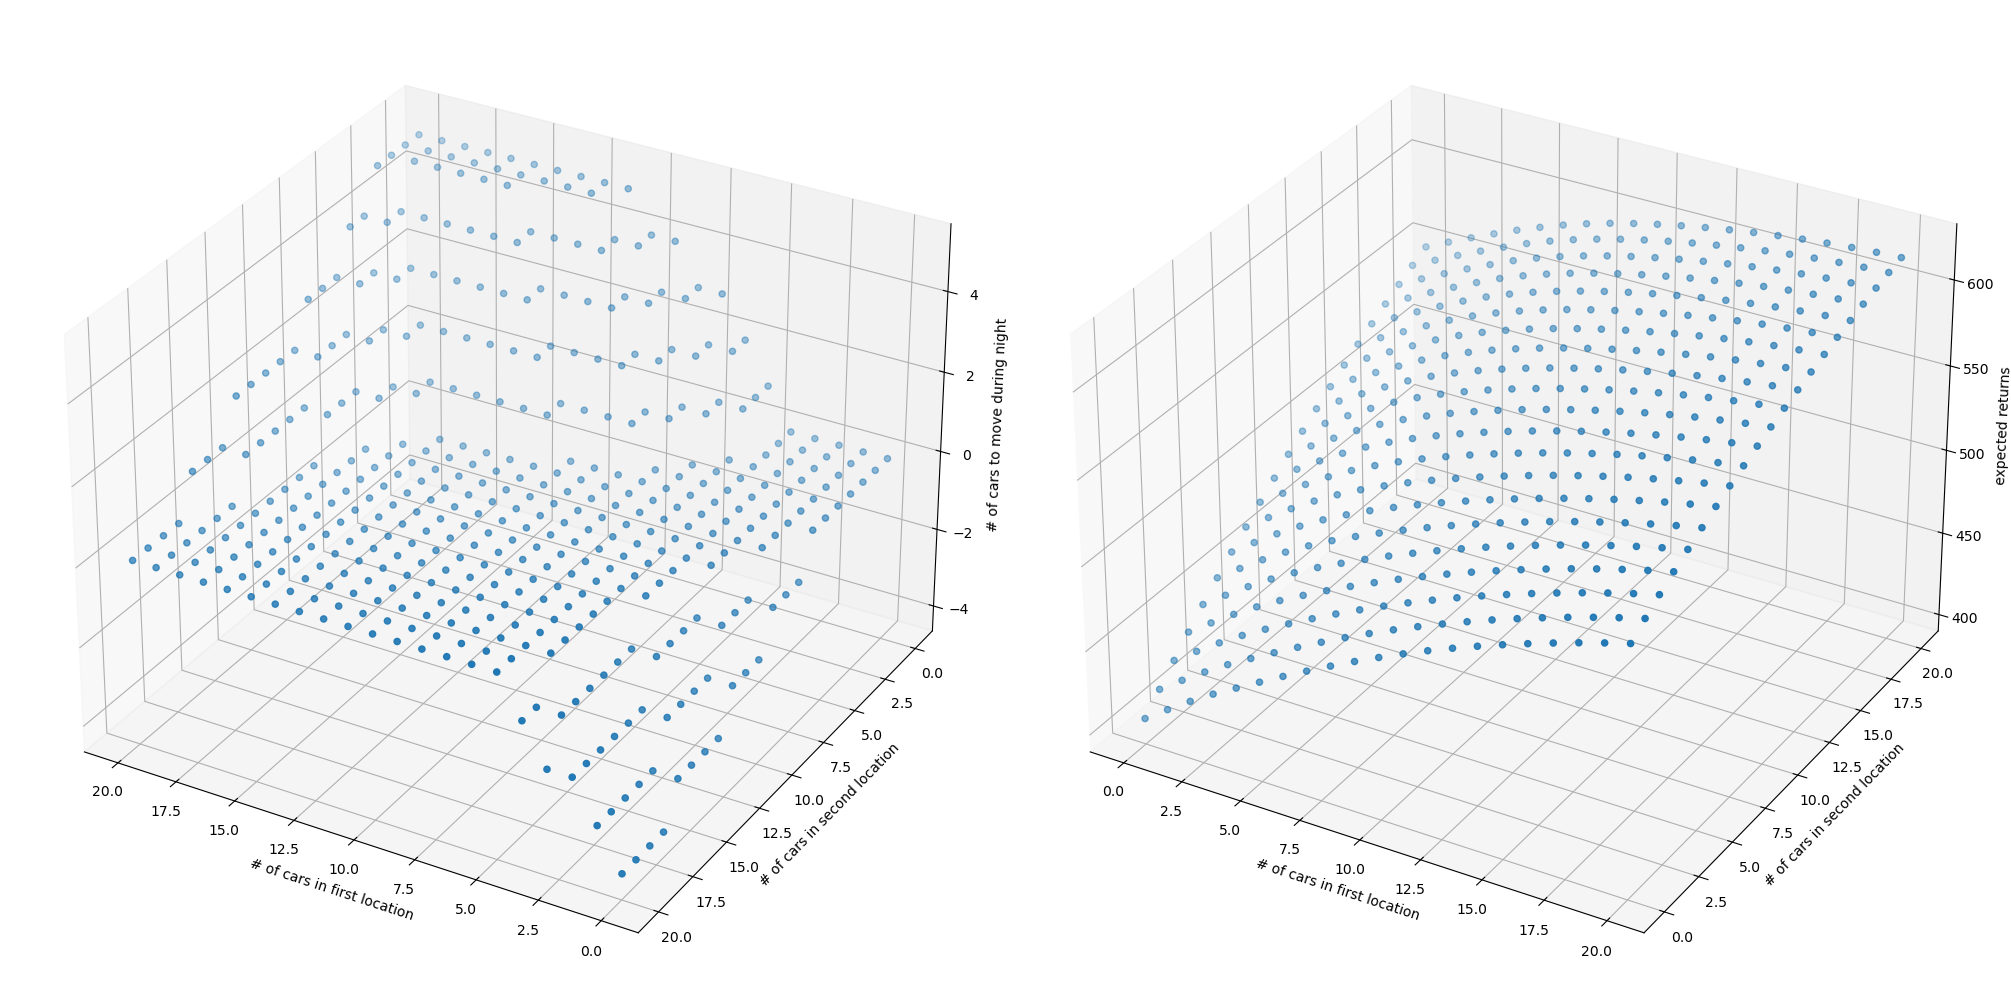

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(20,10), layout="constrained")
ax = fig.add_subplot(1,2,1, projection='3d')

m = 'o'

cars_loc1 = []
cars_loc2 = []
policy_list = []
value_list = []

for i,j in states:
    cars_loc1.append(i)
    cars_loc2.append(j)
    policy_list.append(policy[i,j])
    value_list.append(stateVal[i,j])

ax.scatter(cars_loc1, cars_loc2, policy_list, marker=m)

ax.set_xlabel('# of cars in first location')
ax.set_ylabel('# of cars in second location')
ax.set_zlabel('# of cars to move during night')

ax.xaxis.set_inverted(True)
ax.yaxis.set_inverted(True)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(cars_loc1, cars_loc2, value_list, marker=m)

ax2.set_xlabel('# of cars in first location')
ax2.set_ylabel('# of cars in second location')
ax2.set_zlabel('expected returns')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

plt.show()

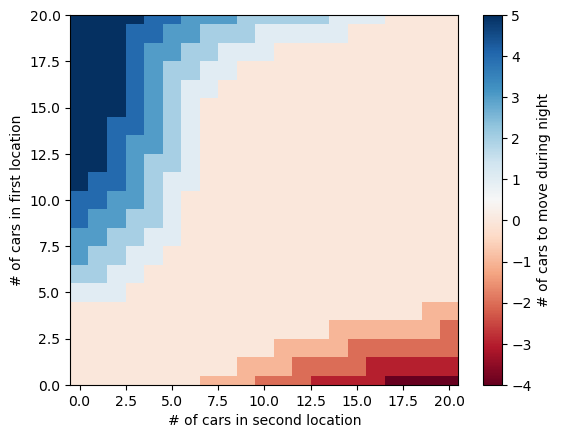

In [23]:
plt.imshow(policy, cmap='RdBu', interpolation='nearest')
plt.ylim([0,20])
cbar = plt.colorbar()
cbar.set_label('# of cars to move during night', rotation=90)


plt.xlabel("# of cars in second location")
plt.ylabel("# of cars in first location")
plt.show()